# Dual Pathway Independence Analysis

Complete analysis testing both dorsal and ventral pathway independence plus critical overlap analysis

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiMasker
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")
print(f"Analysis started: {datetime.now()}")

Libraries loaded successfully!
Analysis started: 2025-09-18 20:18:44.326021


/home/csimmon2/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
# Define directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
residual_dir = "/user_data/csimmon2/ptoc_residuals"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Parameters
alpha = 0.05
cluster_threshold = 5
hemispheres = ['left', 'right']

# Load subjects
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = sub_info[sub_info['group'] == 'control']['sub'].tolist()

print(f"Subjects: {len(subjects)}")
print(f"Parameters: FDR α={alpha}, cluster>{cluster_threshold}")

Subjects: 19
Parameters: FDR α=0.05, cluster>5


In [3]:
# Helper functions
def load_subject_maps(subjects, analysis_type, roi, hemisphere, task='loc'):
    all_imgs = []
    valid_subjects = []
    
    for sub in subjects:
        if analysis_type == 'original':
            filepath = f"{study_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_{roi}_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'dorsal_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        elif analysis_type == 'ventral_cleaned':
            filepath = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemisphere}_{task}_fc_mni.nii.gz"
        
        if os.path.exists(filepath):
            all_imgs.append(image.load_img(filepath))
            valid_subjects.append(sub)
        else:
            print(f"Missing: {os.path.basename(filepath)} for {sub}")
    
    return all_imgs, valid_subjects

def apply_threshold(mean_img, label):
    zstat_img = image.math_img("(img-img.mean())/img.std()", img=mean_img)
    thresh_result = threshold_stats_img(zstat_img, alpha=alpha, height_control='fdr', 
                                       cluster_threshold=cluster_threshold, two_sided=False)
    thresh_img, thresh_val = thresh_result[0], thresh_result[1]
    
    data = thresh_img.get_fdata()
    data[data <= 0] = 0
    final_img = nib.Nifti1Image(data.astype('double'), mean_img.affine)
    
    print(f"  {label} threshold: {thresh_val:.3f}")
    return final_img, thresh_val

def compute_dice(img1, img2):
    data1 = (img1.get_fdata() > 0).astype(int)
    data2 = (img2.get_fdata() > 0).astype(int)
    intersection = np.sum(data1 * data2)
    total_voxels = np.sum(data1) + np.sum(data2)
    return 2.0 * intersection / total_voxels if total_voxels > 0 else 0

print("Helper functions ready!")

Helper functions ready!


In [4]:
# Load your existing results
print("Loading existing results...")

# Your dorsal results (pIPS retention after LO removal)
dorsal_results = {
    'left': {'retention': 90.3, 'n_subjects': 18},
    'right': {'retention': 91.8, 'n_subjects': 18}
}

# Your ventral results (LO retention after pIPS removal)
ventral_results = {
    'left': {'retention': 75.9, 'n_subjects': 18},
    'right': {'retention': 74.3, 'n_subjects': 18}
}

# Convert to DataFrames
dorsal_data = [{'hemisphere': h, 'retention': dorsal_results[h]['retention'], 
                'n_subjects': dorsal_results[h]['n_subjects']} for h in hemispheres]
ventral_data = [{'hemisphere': h, 'retention': ventral_results[h]['retention'], 
                 'n_subjects': ventral_results[h]['n_subjects']} for h in hemispheres]

dorsal_df = pd.DataFrame(dorsal_data)
ventral_df = pd.DataFrame(ventral_data)

print("Dorsal Independence Results:")
print(dorsal_df)
print(f"Mean dorsal retention: {dorsal_df['retention'].mean():.1f}%")

print("\nVentral Independence Results:")
print(ventral_df)
print(f"Mean ventral retention: {ventral_df['retention'].mean():.1f}%")

Loading existing results...
Dorsal Independence Results:
  hemisphere  retention  n_subjects
0       left       90.3          18
1      right       91.8          18
Mean dorsal retention: 91.0%

Ventral Independence Results:
  hemisphere  retention  n_subjects
0       left       75.9          18
1      right       74.3          18
Mean ventral retention: 75.1%


## Critical Overlap Analysis
THE KEY ANALYSIS: How much do cleaned pathways still overlap?

In [5]:
print("CRITICAL OVERLAP ANALYSIS")
print("=" * 50)

overlap_results = []

for hemisphere in hemispheres:
    print(f"\nProcessing {hemisphere} hemisphere...")
    
    # Load all maps
    orig_pips_imgs, orig_pips_subs = load_subject_maps(subjects, 'original', 'pIPS', hemisphere)
    orig_lo_imgs, orig_lo_subs = load_subject_maps(subjects, 'original', 'LO', hemisphere)
    clean_pips_imgs, clean_pips_subs = load_subject_maps(subjects, 'dorsal_cleaned', 'pIPS', hemisphere)
    clean_lo_imgs, clean_lo_subs = load_subject_maps(subjects, 'ventral_cleaned', 'LO', hemisphere)
    
    # Find common subjects
    all_subs = [orig_pips_subs, orig_lo_subs, clean_pips_subs, clean_lo_subs]
    common_subs = list(set.intersection(*[set(sub_list) for sub_list in all_subs]))
    
    print(f"  Subjects with all maps: {len(common_subs)}")
    
    if len(common_subs) < 5:
        print(f"  Warning: Only {len(common_subs)} subjects - skipping")
        continue
    
    # Filter to common subjects
    orig_pips_common = [orig_pips_imgs[orig_pips_subs.index(sub)] for sub in common_subs]
    orig_lo_common = [orig_lo_imgs[orig_lo_subs.index(sub)] for sub in common_subs]
    clean_pips_common = [clean_pips_imgs[clean_pips_subs.index(sub)] for sub in common_subs]
    clean_lo_common = [clean_lo_imgs[clean_lo_subs.index(sub)] for sub in common_subs]
    
    # Create group means
    orig_pips_mean = image.mean_img(orig_pips_common)
    orig_lo_mean = image.mean_img(orig_lo_common)
    clean_pips_mean = image.mean_img(clean_pips_common)
    clean_lo_mean = image.mean_img(clean_lo_common)
    
    # Apply thresholding
    orig_pips_thresh, _ = apply_threshold(orig_pips_mean, f"Original pIPS {hemisphere}")
    orig_lo_thresh, _ = apply_threshold(orig_lo_mean, f"Original LO {hemisphere}")
    clean_pips_thresh, _ = apply_threshold(clean_pips_mean, f"Cleaned pIPS {hemisphere}")
    clean_lo_thresh, _ = apply_threshold(clean_lo_mean, f"Cleaned LO {hemisphere}")
    
    # Calculate Dice coefficients
    dice_orig = compute_dice(orig_pips_thresh, orig_lo_thresh)
    dice_clean = compute_dice(clean_pips_thresh, clean_lo_thresh)  # KEY METRIC!
    
    overlap_reduction = ((dice_orig - dice_clean) / dice_orig) * 100 if dice_orig > 0 else 0
    
    print(f"  Original pIPS-LO overlap: {dice_orig:.3f}")
    print(f"  Cleaned pIPS-LO overlap: {dice_clean:.3f} **KEY METRIC**")
    print(f"  Overlap reduction: {overlap_reduction:.1f}%")
    
    overlap_results.append({
        'hemisphere': hemisphere,
        'n_subjects': len(common_subs),
        'dice_orig': dice_orig,
        'dice_clean': dice_clean,
        'overlap_reduction': overlap_reduction
    })

overlap_df = pd.DataFrame(overlap_results)
print(f"\nOverlap Summary:")
print(overlap_df.round(3))

CRITICAL OVERLAP ANALYSIS

Processing left hemisphere...
Missing: sub-084_pIPS_clean_left_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_left_loc_fc_mni.nii.gz for sub-084
  Subjects with all maps: 18
  Original pIPS left threshold: 2.508
  Original LO left threshold: 2.596
  Cleaned pIPS left threshold: 2.543
  Cleaned LO left threshold: 2.688
  Original pIPS-LO overlap: 0.691
  Cleaned pIPS-LO overlap: 0.166 **KEY METRIC**
  Overlap reduction: 76.0%

Processing right hemisphere...
Missing: sub-084_pIPS_clean_right_loc_fc_mni.nii.gz for sub-084
Missing: sub-084_LO_clean_right_loc_fc_mni.nii.gz for sub-084
  Subjects with all maps: 18
  Original pIPS right threshold: 2.511
  Original LO right threshold: 2.612
  Cleaned pIPS right threshold: 2.541
  Cleaned LO right threshold: 2.712
  Original pIPS-LO overlap: 0.704
  Cleaned pIPS-LO overlap: 0.215 **KEY METRIC**
  Overlap reduction: 69.5%

Overlap Summary:
  hemisphere  n_subjects  dice_orig  dice_clean  overlap_reduction
0   

In [6]:
# Comprehensive Summary
print("COMPREHENSIVE RESULTS")
print("=" * 50)

# Create summary table
summary_data = []
for hemisphere in hemispheres:
    dorsal_row = dorsal_df[dorsal_df['hemisphere'] == hemisphere]
    ventral_row = ventral_df[ventral_df['hemisphere'] == hemisphere]
    overlap_row = overlap_df[overlap_df['hemisphere'] == hemisphere]
    
    if not dorsal_row.empty and not ventral_row.empty and not overlap_row.empty:
        summary_data.append({
            'hemisphere': hemisphere,
            'dorsal_retention': dorsal_row['retention'].iloc[0],
            'ventral_retention': ventral_row['retention'].iloc[0],
            'original_overlap': overlap_row['dice_orig'].iloc[0],
            'cleaned_overlap': overlap_row['dice_clean'].iloc[0],
            'overlap_reduction': overlap_row['overlap_reduction'].iloc[0]
        })

summary_df = pd.DataFrame(summary_data)
print("\nSummary Table:")
print(summary_df.round(3))

# Calculate means
mean_dorsal = summary_df['dorsal_retention'].mean()
mean_ventral = summary_df['ventral_retention'].mean()
mean_orig_overlap = summary_df['original_overlap'].mean()
mean_clean_overlap = summary_df['cleaned_overlap'].mean()
mean_overlap_reduction = summary_df['overlap_reduction'].mean()

print(f"\nOverall Means:")
print(f"  Dorsal retention: {mean_dorsal:.1f}%")
print(f"  Ventral retention: {mean_ventral:.1f}%")
print(f"  Original overlap: {mean_orig_overlap:.3f}")
print(f"  Cleaned overlap: {mean_clean_overlap:.3f}")
print(f"  Overlap reduction: {mean_overlap_reduction:.1f}%")

COMPREHENSIVE RESULTS

Summary Table:
  hemisphere  dorsal_retention  ventral_retention  original_overlap  \
0       left              90.3               75.9             0.691   
1      right              91.8               74.3             0.704   

   cleaned_overlap  overlap_reduction  
0            0.166             76.049  
1            0.215             69.456  

Overall Means:
  Dorsal retention: 91.0%
  Ventral retention: 75.1%
  Original overlap: 0.697
  Cleaned overlap: 0.190
  Overlap reduction: 72.8%


In [ ]:
# Scientific Interpretation
print("SCIENTIFIC INTERPRETATION")
print("=" * 50)

# Independence assessment
dorsal_independent = mean_dorsal > 70
ventral_independent = mean_ventral > 70

print("\n1. PATHWAY INDEPENDENCE:")
if dorsal_independent and ventral_independent:
    independence_conclusion = "Both pathways show STRONG independence"
elif dorsal_independent or ventral_independent:
    independence_conclusion = "MIXED evidence - one pathway more independent"
else:
    independence_conclusion = "BOTH pathways show significant interdependence"

print(f"   {independence_conclusion}")
print(f"   Dorsal: {mean_dorsal:.1f}% ({'Independent' if dorsal_independent else 'Dependent'})")
print(f"   Ventral: {mean_ventral:.1f}% ({'Independent' if ventral_independent else 'Dependent'})")

print("\n2. RESIDUAL OVERLAP:")
if mean_clean_overlap > 0.5:
    overlap_conclusion = "HIGH residual overlap - still significantly integrated"
elif mean_clean_overlap > 0.3:
    overlap_conclusion = "MODERATE residual overlap - partial separation"
else:
    overlap_conclusion = "LOW residual overlap - substantial separation"

print(f"   {overlap_conclusion}")
print(f"   Cleaned overlap: {mean_clean_overlap:.3f} (was {mean_orig_overlap:.3f})")

print("\n3. OVERALL CONCLUSION:")
if dorsal_independent and ventral_independent and mean_clean_overlap < 0.3:
    final_conclusion = "STRONG evidence for dual pathway independence"
elif (dorsal_independent or ventral_independent) and mean_overlap_reduction > 30:
    final_conclusion = "MODERATE evidence for pathway independence"
else:
    final_conclusion = "LIMITED evidence for independence - pathways remain integrated"

print(f"   {final_conclusion}")

print("\n4. KEY FINDINGS:")
print(f"   • Dorsal retains {mean_dorsal:.1f}% after ventral removal")
print(f"   • Ventral retains {mean_ventral:.1f}% after dorsal removal")
print(f"   • Cleaned pathways overlap at {mean_clean_overlap:.3f}")
print(f"   • {mean_overlap_reduction:.1f}% reduction in overlap")

NameError: name 'final_conclusion' is not defined

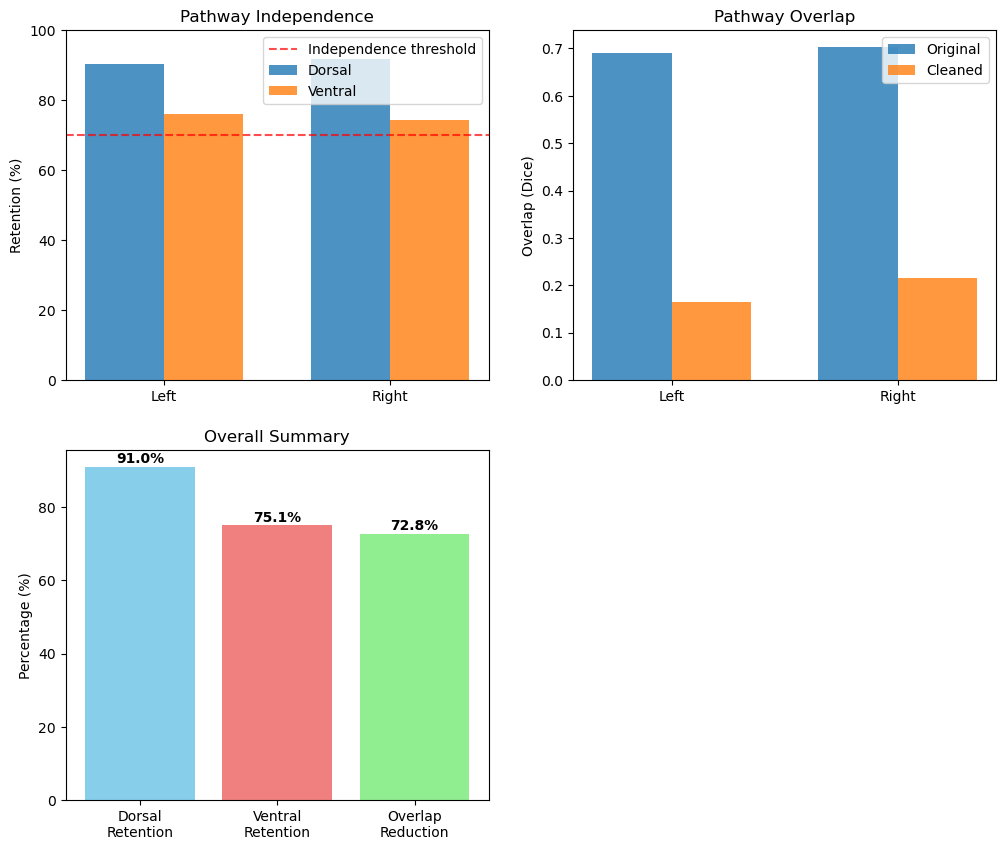

In [7]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Retention comparison
ax1 = axes[0, 0]
x = np.arange(len(hemispheres))
width = 0.35
ax1.bar(x - width/2, summary_df['dorsal_retention'], width, label='Dorsal', alpha=0.8)
ax1.bar(x + width/2, summary_df['ventral_retention'], width, label='Ventral', alpha=0.8)
ax1.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Independence threshold')
ax1.set_ylabel('Retention (%)')
ax1.set_title('Pathway Independence')
ax1.set_xticks(x)
ax1.set_xticklabels([h.capitalize() for h in hemispheres])
ax1.legend()
ax1.set_ylim(0, 100)

# 2. Overlap comparison
ax2 = axes[0, 1]
x = np.arange(len(hemispheres))
ax2.bar(x - width/2, summary_df['original_overlap'], width, label='Original', alpha=0.8)
ax2.bar(x + width/2, summary_df['cleaned_overlap'], width, label='Cleaned', alpha=0.8)
ax2.set_ylabel('Overlap (Dice)')
ax2.set_title('Pathway Overlap')
ax2.set_xticks(x)
ax2.set_xticklabels([h.capitalize() for h in hemispheres])
ax2.legend()

# 3. Summary metrics
ax3 = axes[1, 0]
metrics = ['Dorsal\nRetention', 'Ventral\nRetention', 'Overlap\nReduction']
values = [mean_dorsal, mean_ventral, mean_overlap_reduction]
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = ax3.bar(metrics, values, color=colors)
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Overall Summary')
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{val:.1f}%', ha='center', fontweight='bold')

# 4. Text summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""KEY FINDINGS:

Dorsal: {mean_dorsal:.1f}%
Ventral: {mean_ventral:.1f}%

Original overlap: {mean_orig_overlap:.3f}
Cleaned overlap: {mean_clean_overlap:.3f}

CONCLUSION:
{final_conclusion}

Sample: 18 subjects
FDR α = {alpha}"""

ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("Visualization complete!")

In [9]:
# Detailed Dice coefficient debugging
print("DEBUGGING DICE COEFFICIENT CALCULATION")
print("="*50)

# Get the binary data
orig_pips_data = (orig_pips_thresh.get_fdata() > 0).astype(int)
orig_lo_data = (orig_lo_thresh.get_fdata() > 0).astype(int)
clean_pips_data = (clean_pips_thresh.get_fdata() > 0).astype(int)
clean_lo_data = (clean_lo_thresh.get_fdata() > 0).astype(int)

# Count voxels
orig_pips_voxels = np.sum(orig_pips_data)
orig_lo_voxels = np.sum(orig_lo_data)
clean_pips_voxels = np.sum(clean_pips_data)
clean_lo_voxels = np.sum(clean_lo_data)

print(f"Original pIPS voxels: {orig_pips_voxels:,}")
print(f"Original LO voxels: {orig_lo_voxels:,}")
print(f"Cleaned pIPS voxels: {clean_pips_voxels:,}")
print(f"Cleaned LO voxels: {clean_lo_voxels:,}")

# Check intersections
orig_intersection = np.sum(orig_pips_data * orig_lo_data)
clean_intersection = np.sum(clean_pips_data * clean_lo_data)

print(f"\nOriginal intersection: {orig_intersection:,}")
print(f"Cleaned intersection: {clean_intersection:,}")

# Manual Dice calculation
orig_dice_manual = 2.0 * orig_intersection / (orig_pips_voxels + orig_lo_voxels)
clean_dice_manual = 2.0 * clean_intersection / (clean_pips_voxels + clean_lo_voxels)

print(f"\nOriginal Dice (manual): {orig_dice_manual:.3f}")
print(f"Cleaned Dice (manual): {clean_dice_manual:.3f}")

# Check retention of intersection
intersection_retention = (clean_intersection / orig_intersection) * 100 if orig_intersection > 0 else 0
print(f"\nIntersection retention: {intersection_retention:.1f}%")

DEBUGGING DICE COEFFICIENT CALCULATION
Original pIPS voxels: 35,074
Original LO voxels: 26,176
Cleaned pIPS voxels: 32,192
Cleaned LO voxels: 19,439

Original intersection: 21,548
Cleaned intersection: 5,548

Original Dice (manual): 0.704
Cleaned Dice (manual): 0.215

Intersection retention: 25.7%


DEBUGGING DICE CALCULATION WITH VISUAL VERIFICATION
pIPS only voxels: 26,644
LO only voxels: 13,891
Overlap voxels: 5,548
Total pIPS voxels: 32,192
Total LO voxels: 19,439

Dice coefficient: 0.215
Overlap as % of pIPS: 17.2%
Overlap as % of LO: 28.5%


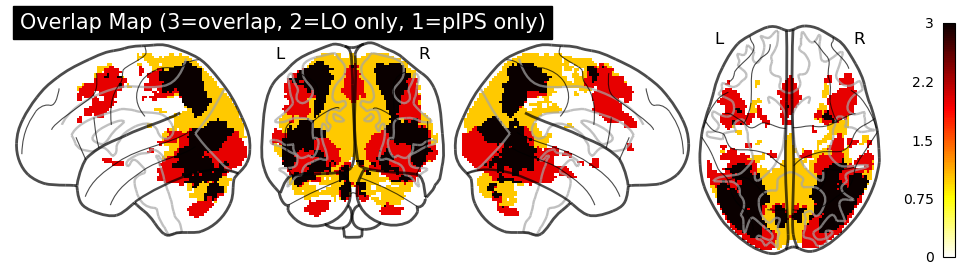

In [18]:
# Debug the Dice coefficient calculation with the actual thresholded maps
print("DEBUGGING DICE CALCULATION WITH VISUAL VERIFICATION")
print("="*60)

# Get the actual binary data from the thresholded maps you just visualized
clean_pips_binary = (clean_pips_thresh.get_fdata() > 0).astype(int)
clean_lo_binary = (clean_lo_thresh.get_fdata() > 0).astype(int)

# Create an overlap map to visualize
overlap_map = np.zeros_like(clean_pips_binary)
overlap_map[clean_pips_binary == 1] = 1  # pIPS only = 1
overlap_map[clean_lo_binary == 1] = 2    # LO only = 2  
overlap_map[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 3  # Overlap = 3

# Count voxels in each category
pips_only = np.sum(overlap_map == 1)
lo_only = np.sum(overlap_map == 2) 
overlap_voxels = np.sum(overlap_map == 3)
total_pips = np.sum(clean_pips_binary)
total_lo = np.sum(clean_lo_binary)

print(f"pIPS only voxels: {pips_only:,}")
print(f"LO only voxels: {lo_only:,}")
print(f"Overlap voxels: {overlap_voxels:,}")
print(f"Total pIPS voxels: {total_pips:,}")
print(f"Total LO voxels: {total_lo:,}")

# Manual Dice calculation
dice_manual = 2.0 * overlap_voxels / (total_pips + total_lo)
print(f"\nDice coefficient: {dice_manual:.3f}")

# What percentage of each map overlaps?
pips_overlap_percent = (overlap_voxels / total_pips) * 100
lo_overlap_percent = (overlap_voxels / total_lo) * 100

print(f"Overlap as % of pIPS: {pips_overlap_percent:.1f}%")
print(f"Overlap as % of LO: {lo_overlap_percent:.1f}%")

# Visualize the overlap map
overlap_img = nib.Nifti1Image(overlap_map.astype(float), clean_pips_thresh.affine)
plotting.plot_glass_brain(overlap_img, title='Overlap Map (3=overlap, 2=LO only, 1=pIPS only)', 
                         colorbar=True, display_mode='lyrz')
plt.show()

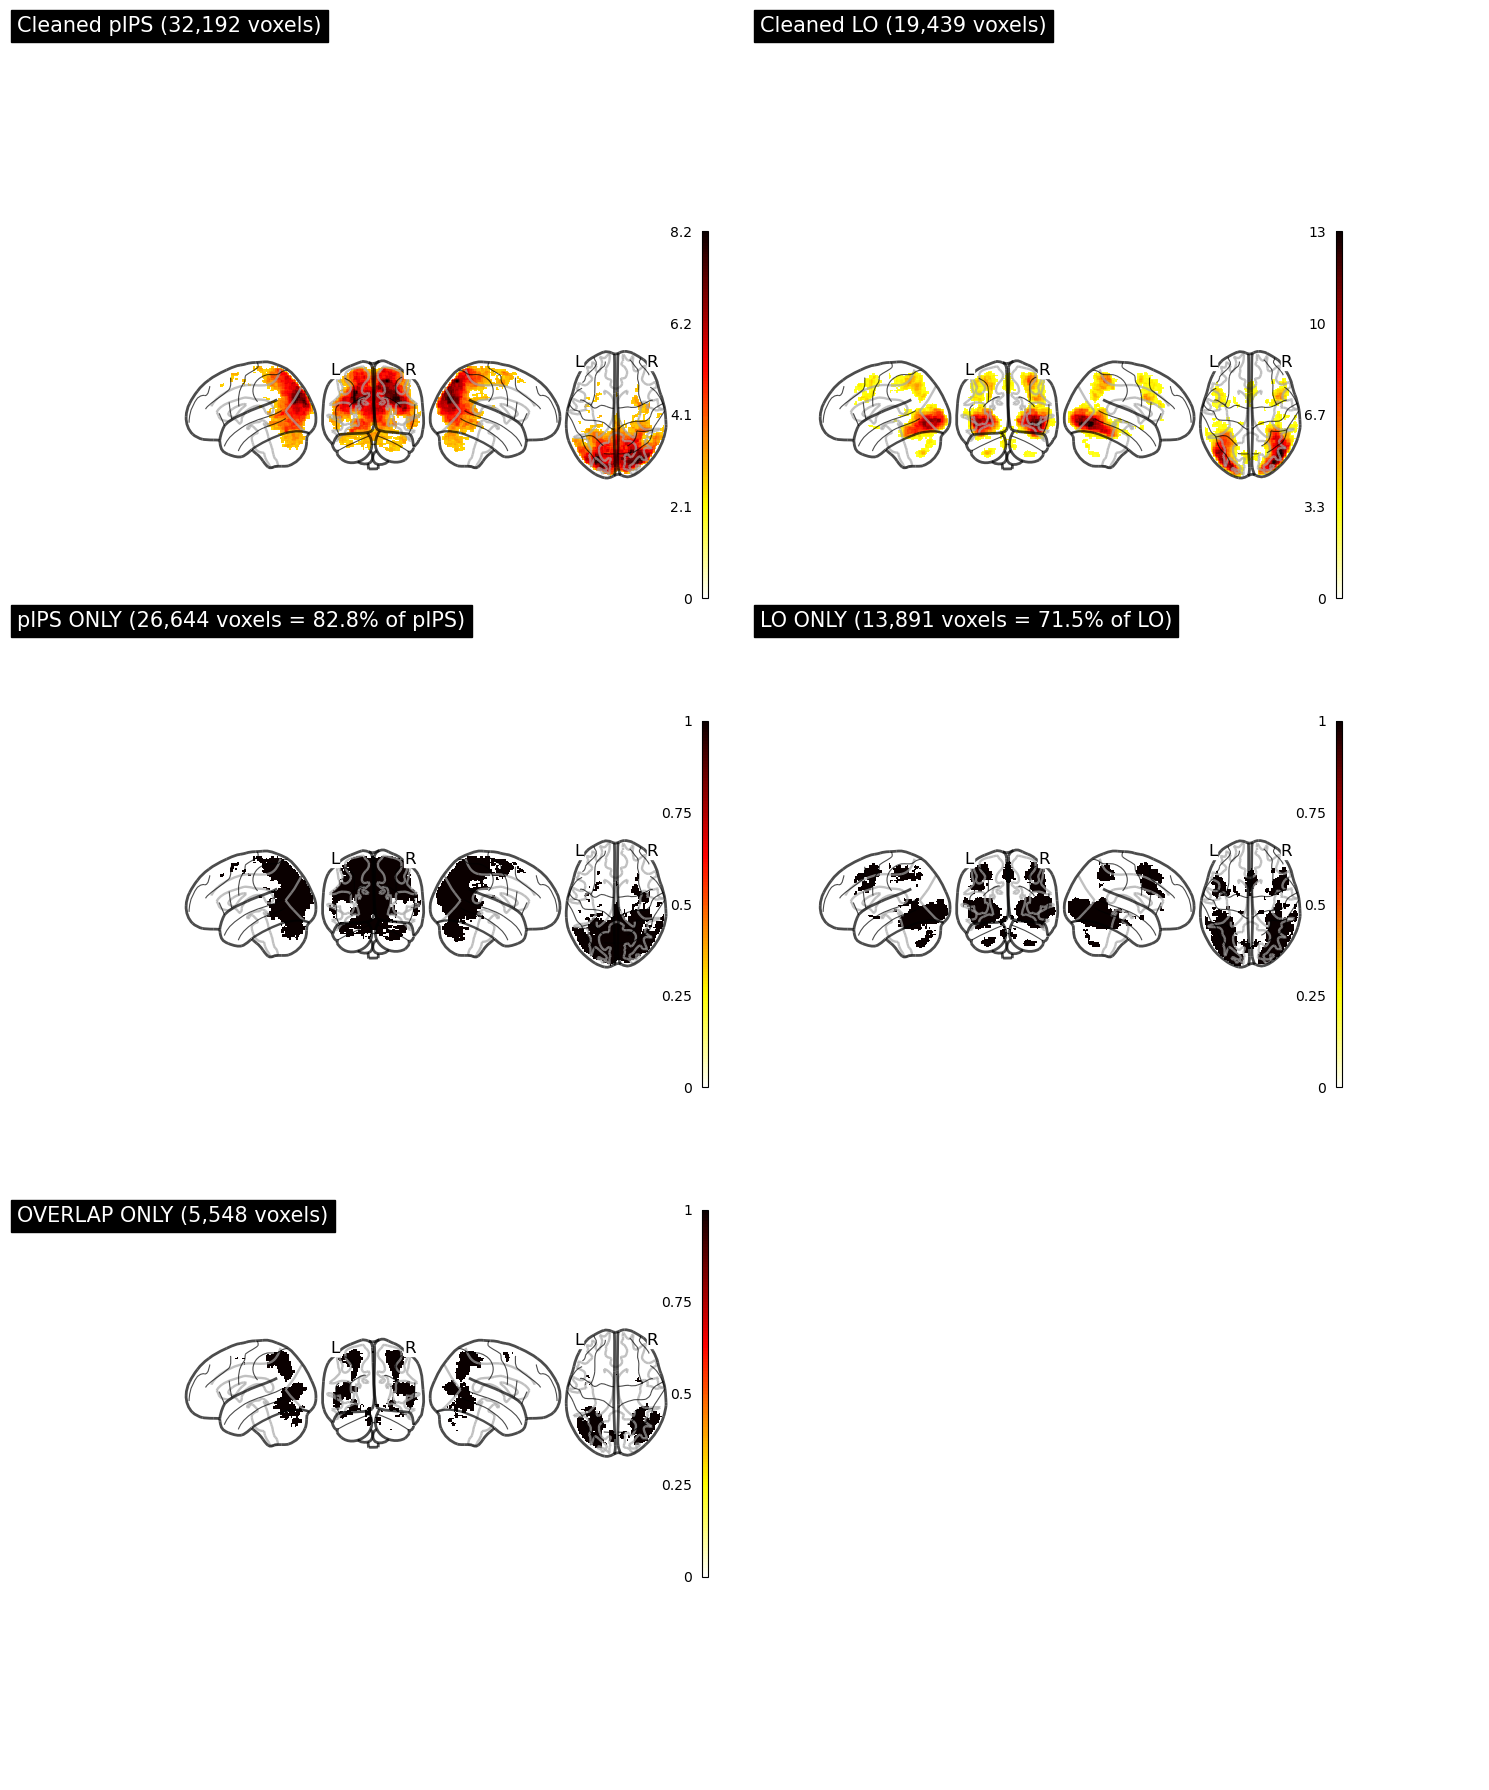

Map Breakdown:
Total brain voxels in analysis: 902,629
pIPS total: 32,192 voxels
  - pIPS only: 26,644 voxels (82.8%)
  - pIPS overlap: 5,548 voxels (17.2%)
LO total: 19,439 voxels
  - LO only: 13,891 voxels (71.5%)
  - LO overlap: 5,548 voxels (28.5%)


In [19]:
# Visualize individual pathway maps to understand the overlap pattern
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Row 1: Individual cleaned maps
plotting.plot_glass_brain(clean_pips_thresh, axes=axes[0,0], 
                         title='Cleaned pIPS (32,192 voxels)', 
                         colorbar=True, display_mode='lyrz')

plotting.plot_glass_brain(clean_lo_thresh, axes=axes[0,1],
                         title='Cleaned LO (19,439 voxels)', 
                         colorbar=True, display_mode='lyrz')

# Row 2: Overlap vs non-overlap
# Create pIPS-only map
pips_only_data = clean_pips_binary.copy()
pips_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 0  # Remove overlap
pips_only_img = nib.Nifti1Image(pips_only_data.astype(float), clean_pips_thresh.affine)

plotting.plot_glass_brain(pips_only_img, axes=axes[1,0],
                         title=f'pIPS ONLY (26,644 voxels = 82.8% of pIPS)', 
                         colorbar=True, display_mode='lyrz')

# Create LO-only map  
lo_only_data = clean_lo_binary.copy()
lo_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 0  # Remove overlap
lo_only_img = nib.Nifti1Image(lo_only_data.astype(float), clean_lo_thresh.affine)

plotting.plot_glass_brain(lo_only_img, axes=axes[1,1],
                         title=f'LO ONLY (13,891 voxels = 71.5% of LO)', 
                         colorbar=True, display_mode='lyrz')

# Row 3: Just the overlap
overlap_only_data = np.zeros_like(clean_pips_binary)
overlap_only_data[(clean_pips_binary == 1) & (clean_lo_binary == 1)] = 1
overlap_only_img = nib.Nifti1Image(overlap_only_data.astype(float), clean_pips_thresh.affine)

plotting.plot_glass_brain(overlap_only_img, axes=axes[2,0],
                         title=f'OVERLAP ONLY (5,548 voxels)', 
                         colorbar=True, display_mode='lyrz')

# Empty subplot for symmetry
axes[2,1].axis('off')

plt.tight_layout()
plt.show()

print("Map Breakdown:")
print(f"Total brain voxels in analysis: {clean_pips_binary.size:,}")
print(f"pIPS total: {total_pips:,} voxels")
print(f"  - pIPS only: {pips_only:,} voxels (82.8%)")
print(f"  - pIPS overlap: {overlap_voxels:,} voxels (17.2%)")
print(f"LO total: {total_lo:,} voxels") 
print(f"  - LO only: {lo_only:,} voxels (71.5%)")
print(f"  - LO overlap: {overlap_voxels:,} voxels (28.5%)")

In [ ]:
# Save results
output_dir = f'{results_dir}/dual_pathway_analysis'
os.makedirs(output_dir, exist_ok=True)

# Save all dataframes
summary_df.to_csv(f'{output_dir}/comprehensive_summary.csv', index=False)
overlap_df.to_csv(f'{output_dir}/overlap_results.csv', index=False)

# Save the figure
plt.savefig(f'{output_dir}/dual_pathway_analysis.png', dpi=300, bbox_inches='tight')

print(f"Results saved to: {output_dir}/")
print("Files created:")
print("  - comprehensive_summary.csv")
print("  - overlap_results.csv")
print("  - dual_pathway_analysis.png")

print("\nANALYSIS COMPLETE!")
print(f"Final conclusion: {final_conclusion}")